# Clasificación de ciberbullying (Gráfico)

**Nombre:** Leobardo García Reyes

**Matrícula:** 1616825

# Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.4 MB/s 


In [3]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

# Carga de datos

## Lectura de datos

In [4]:
Datos = pd.read_csv('/content/drive/MyDrive/Tarea 3/cyberbullying_tweets.csv', encoding = 'latin-1')
Datos.head(2)

,tweet_text,cyberbullying_type
0,Having some real sympathy for Twitter right now.,other_cyberbullying
1,The final is in November #MKR,other_cyberbullying


## Manipulación de datos

In [5]:
#Datos.rename(columns = {'tweet_text': 'Texto', 'cyberbullying_type': 'Tipo_Bullying'}).head(2)
TText = pd.DataFrame({'Texto': Datos['tweet_text'], 'Tipo_Bullying': Datos['cyberbullying_type']})
TText.head()

,Texto,Tipo_Bullying
0,Having some real sympathy for Twitter right now.,other_cyberbullying
1,The final is in November #MKR,other_cyberbullying
2,"RT @LouisRITHPotter I'm not sexist, but someti...",gender
3,@MrAlMubarak Allah the terrorist can stick wha...,religion
4,@Sushilulutwitch @Spacekatgal Glad to hear fro...,not_cyberbullying


In [6]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(TText.shape))
print('\n')
print(TText.columns)

Dimensiones: (47692, 2)


Index(['Texto', 'Tipo_Bullying'], dtype='object')


In [7]:
N = 47692
TText = TText.iloc[:30000, :]
TText.shape

(30000, 2)

# Limpieza de texto

In [8]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', '', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [9]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['Texto_Limpio'] = TText['Texto'].apply(lambda x: Limpiar_texto(x))
TText[['Texto', 'Tipo_Bullying', 'Texto_Limpio']].head(3)

,Texto,Tipo_Bullying,Texto_Limpio
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr
2,"RT @LouisRITHPotter I'm not sexist, but someti...",gender,rt louisrithpotter i m not sexist but sometime...


## Stopwords

In [10]:
# Stopwords en ingles
sw = stopwords.words('english')

# Nuevas stopwords
nuevas_sw = ('one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
             'rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's')

for i in nuevas_sw:
    sw.append(i)

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Diccionario POS

In [11]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['Texto_Pos'] = TText['Texto_Limpio'].apply(token_stop_pos)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ..."
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]"


## Lematización

In [12]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['Lema'] = TText['Texto_Pos'].apply(lemmatize)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november


In [13]:
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['Mayores'] = TText['Lema'].apply(mayores)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema,Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right,"[real, sympathy, twitter, right]"
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november,"[final, november]"


In [14]:
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['Lema_Mayores'] = TText['Mayores'].apply(lema_mayores)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right,"[real, sympathy, twitter, right]",real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november,"[final, november]",final november


In [15]:
Texto_final = TText.loc[:, ['Texto', 'Tipo_Bullying', 'Lema_Mayores']]
Texto_final.head(2)

,Texto,Tipo_Bullying,Lema_Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,final november


In [16]:
Texto_final['Categoria_ID'] = Texto_final['Tipo_Bullying'].factorize()[0]
Categoria_ID_datos = Texto_final[['Tipo_Bullying', 'Categoria_ID']].drop_duplicates().sort_values('Categoria_ID')
Categoria_a_ID = dict(Categoria_ID_datos.values)
ID_a_Categoria = dict(Categoria_ID_datos[['Categoria_ID', 'Tipo_Bullying']].values)
Texto_final.head(2)

,Texto,Tipo_Bullying,Lema_Mayores,Categoria_ID
0,Having some real sympathy for Twitter right now.,other_cyberbullying,real sympathy twitter right,0
1,The final is in November #MKR,other_cyberbullying,final november,0


In [17]:
Tabla_Conteo = Texto_final['Tipo_Bullying'].value_counts()
Tabla_Conteo

age                    5091
gender                 5052
not_cyberbullying      5025
religion               4971
other_cyberbullying    4931
ethnicity              4930
Name: Tipo_Bullying, dtype: int64

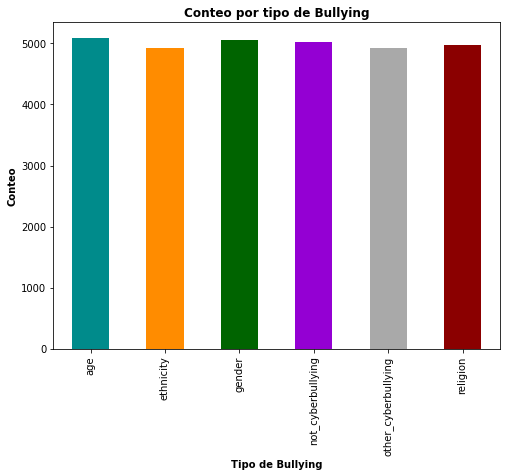

In [18]:
color = ['darkcyan', 'darkorange', 'darkgreen', 'darkviolet', 'darkgray', 'darkred']
fig = plt.figure(figsize=(8,6))
Texto_final.groupby('Tipo_Bullying').Lema_Mayores.count().plot.bar(ylim=0, color=color)
plt.title('Conteo por tipo de Bullying', fontweight = 'bold')
plt.xlabel('Tipo de Bullying', fontweight = 'bold')
plt.ylabel('Conteo', fontweight = 'bold')
plt.show()

# Gráficos

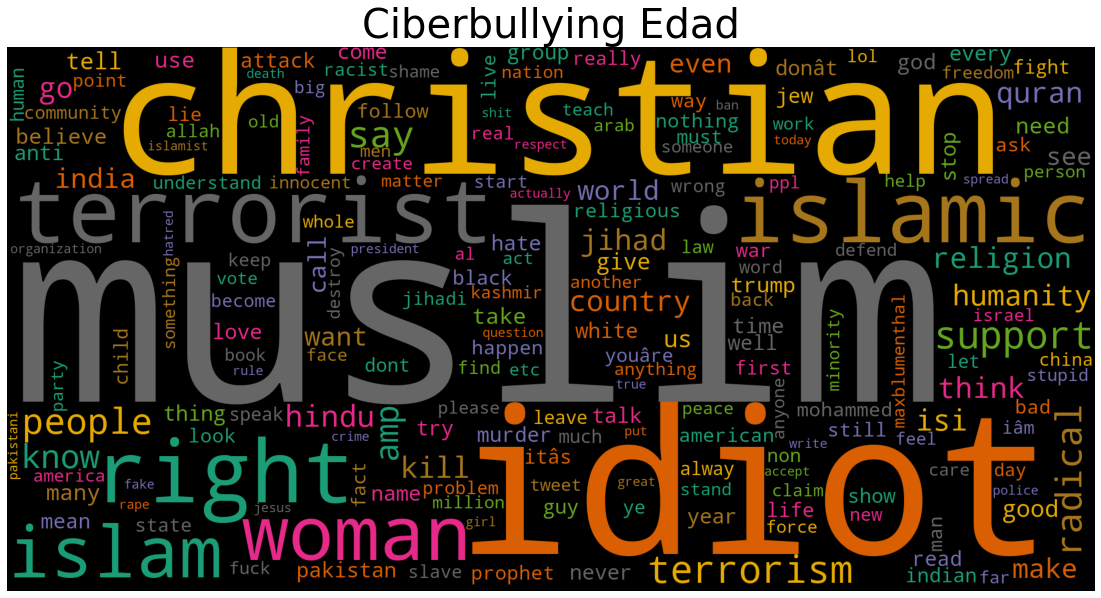

In [34]:
# Generar nube de palabras
plt.figure(figsize=(20,10))
metodo = Texto_final[Texto_final['Tipo_Bullying']=='religion']
text_nube = metodo.Lema_Mayores.values
cloud1=WordCloud(background_color = 'black', colormap = 'Dark2', collocations = False,
                 width = 2000, height = 1000).generate(' '.join(text_nube))

plt.axis('off')
plt.title('Ciberbullying Edad', fontsize = 40)
plt.imshow(cloud1)

In [35]:
texto_analizar = metodo['Lema_Mayores']
tokenizar = [cadena.split() for cadena in texto_analizar]
descripcion = []
for cadena in tokenizar:
    for i in cadena:
        descripcion.append(i)

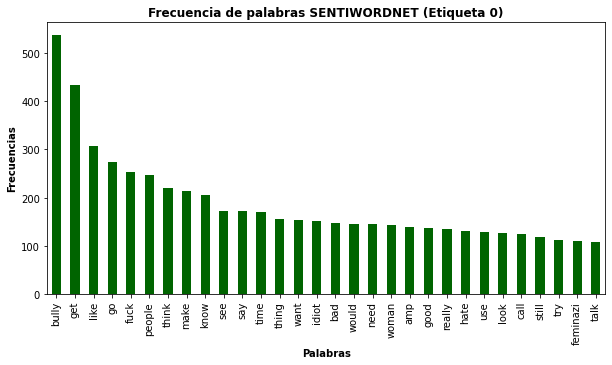

In [33]:
def gra_pa(datos, titulo = None):
    aux = pd.Series(datos)
    aux.value_counts()[:30].plot.bar(figsize = (10, 5), color = 'darkgreen')
    if titulo: 
        plt.title(titulo, fontweight = 'bold')
    plt.xlabel('Palabras', fontweight = 'bold')
    plt.ylabel('Frecuencias', fontweight = 'bold')

gra_pa(descripcion, titulo = 'Frecuencia de palabras SENTIWORDNET (Etiqueta 0)')